In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import time

In [3]:
import os
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/')
import triplet

### Get Data

In [4]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [5]:
def front_or_back(img_path, train=True):
    DATA_ROOT = '/home/albert/caffe/'
    
    if img_path.find('/') > -1:
        root = img_path[len(img_path) - img_path[::-1].index('/'):-4:]
    else:
        root = img_path[0:img_path.index('.')]

    if train:
        keypoint_path = DATA_ROOT + 'data/market-1501/train_openpose/train_keypoints/%s_keypoints.json' % root
    else:
        keypoint_path = DATA_ROOT + 'data/market-1501/test_openpose/test_keypoints/%s_keypoints.json' % root
    
    with open(keypoint_path) as data_file:
        data = json.load(data_file)
    
    keypoints = []
    
    for person in range(len(data['people'])):
        keypoints.append({'x' : [], 'y' : [], 'c' : []})
        for i in range(0, len(data['people'][person]['pose_keypoints']), 3):
            x_key = data['people'][person]['pose_keypoints'][i]
            y_key = data['people'][person]['pose_keypoints'][i + 1]
            c_key = data['people'][person]['pose_keypoints'][i + 2]
            
            keypoints[person]['x'].append(x_key)
            keypoints[person]['y'].append(y_key)
            keypoints[person]['c'].append(c_key)
    
    for person in range(len(keypoints)):
        if keypoints[person]['x'][2] < keypoints[person]['x'][5]:
            return 'front'
        else:
            return 'back'

In [6]:
front_train_dict = {}
front_train_files = []
front_train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        if front_or_back(path, train=True) == 'front':
            idt = int(f[0:f.index('_')])
            if not any(idt == l for l in front_train_labels):
                front_train_labels.append(idt)
                front_train_dict[idt] = []

            front_train_files.append([path, idt])
            front_train_dict[idt].append(path)

front_train_labels.sort()

front_test_dict = {}
front_test_files = []
front_test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
        if front_or_back(path, train=False) == 'front':
            idt = int(f[0:f.index('_')])
            if idt != 0 and idt != -1:
                if not any(idt == l for l in front_test_labels):
                    front_test_labels.append(idt)
                    front_test_dict[idt] = []

                front_test_files.append([path, idt])
                front_test_dict[idt].append(path)

front_test_labels.sort()

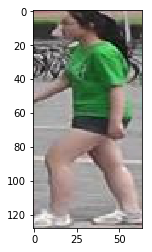

In [7]:
plt.imshow(misc.imread(front_test_files[3][0]))

In [8]:
back_train_dict = {}
back_train_files = []
back_train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        if front_or_back(path, train=True) == 'back':
            idt = int(f[0:f.index('_')])
            if not any(idt == l for l in back_train_labels):
                back_train_labels.append(idt)
                back_train_dict[idt] = []

            back_train_files.append([path, idt])
            back_train_dict[idt].append(path)

back_train_labels.sort()

back_test_dict = {}
back_test_files = []
back_test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
        if front_or_back(path, train=False) == 'back':
            idt = int(f[0:f.index('_')])
            if idt != 0 and idt != -1:
                if not any(idt == l for l in back_test_labels):
                    back_test_labels.append(idt)
                    back_test_dict[idt] = []

                back_test_files.append([path, idt])
                back_test_dict[idt].append(path)

back_test_labels.sort()

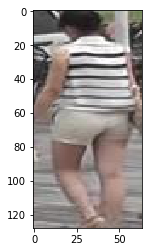

In [9]:
plt.imshow(misc.imread(back_test_files[1][0]))

False
True
0.815454006195


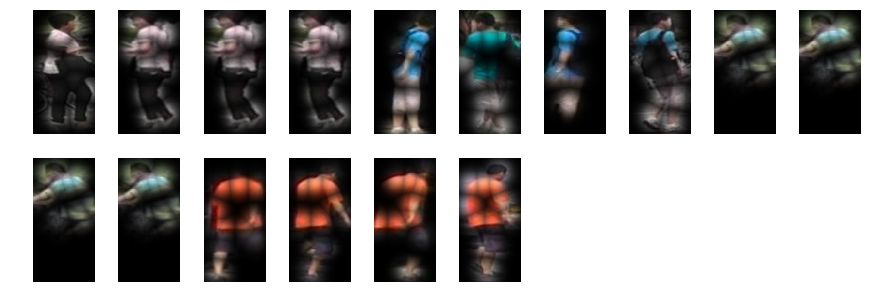

In [10]:
start = time.time()
batch = triplet.output_batch_generator(back_train_dict, back_train_labels, overlay=True, preprocess=False, 
                                                        shape=(256,128)).next()
print time.time() - start

plt.figure(figsize=(15,5))
for i in range(16):
    plt.subplot(2,10,i+1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.axis('off')
plt.show()

### Train Network

In [11]:
train_score = {}
test_score = {}

steps_per_epoch = 100

input_shape = (256,128)

overlay = True
overlay_eval = True
preprocess = True

file_root = 'densenet_triplet_front_256x128'

In [12]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

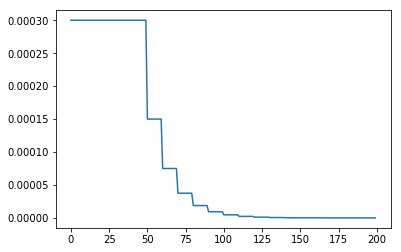

In [13]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [14]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

In [ ]:
base_model = densenet.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

x = base_model.outputs[0]
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

trinet = Model(inputs=base_model.input, outputs=predictions)
trinet.compile(loss=triplet.triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

In [ ]:
history = History()

for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(triplet.output_batch_generator(front_train_dict, front_train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet.get_score(trinet, front_train_dict, front_train_files, hist=history, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                               shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet.get_score(trinet, front_test_dict, front_test_files, hist=history, 
                                        overlay=overlay_eval, train=False, preprocess=preprocess, 
                                               shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

### Evaluation

In [15]:
model = load_model('/home/albert/github/tensorflow/models/densenet_triplet_front_256x128/densenet_triplet_front_256x128_15000.h5', 
                   custom_objects={'triplet_loss' : triplet.triplet_loss})

In [16]:
front_train_dict_2 = {}
front_train_files_2 = []

idt_at_least_2 = []

for idt in front_train_dict.keys():
    if len(front_train_dict[idt]) > 1:
        idt_at_least_2.append(idt)
        front_train_dict_2[idt] = front_train_dict[idt]

for f in front_train_files:
    try:
        x = idt_at_least_2.index(f[1])
        front_train_files_2.append(f)
    except ValueError:
        pass

In [17]:
front_train_len = [len(front_train_dict_2[idt]) for idt in front_train_dict_2.keys()]

l = np.array(front_train_len)
np.where(l == 1)

(array([], dtype=int64),)

In [18]:
front_test_dict_2 = {}
front_test_files_2 = []

idt_at_least_2_2 = []

for idt in front_test_dict.keys():
    if len(front_test_dict[idt]) > 1:
        idt_at_least_2_2.append(idt)
        front_test_dict_2[idt] = front_test_dict[idt]

for f in front_test_files_2:
    try:
        x = idt_at_least_2_2.index(f[1])
        front_test_files_2.append(f)
    except ValueError:
        pass

In [ ]:
front_test_len = [len(front_test_dict_2[idt]) for idt in front_test_dict_2.keys()]

l = np.array(front_test_len)
np.where(l == 1)

(array([], dtype=int64),)

In [ ]:
train_score = triplet.get_score(model, front_train_dict_2, front_train_files_2, hist=None, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                           shape=input_shape)

preprocess True
overlay True
train True
1000 31.0020651817
2000 61.1153540611
3000 91.4991540909
4000 121.58605504
5000 151.523802042
6000 182.706797123


In [ ]:
print 'train'
plot_score(train_score)

In [41]:
test_score = triplet.get_score(model, front_test_dict_2, front_test_files_2, hist=None, 
                                    overlay=overlay_eval, train=False, preprocess=preprocess, 
                                           shape=input_shape)
print 'test'
plot_score(test_score)

preprocess True
overlay True
train False


ValueError: a must be non-empty